In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from esn.esn import DeepESN, DeepSubreservoirESN
from esn import activation as A
from esn.initialization import *
from scipy.integrate import odeint
import torch
np.random.seed(42)

In [2]:
device = torch.device('cpu')
dtype = torch.double
torch.set_default_dtype(dtype)

In [3]:
pat_2 = pd.read_csv('data/abc_pat_2.csv')
pat_8 = pd.read_csv('data/abc_pat_8.csv')
pat_17 = pd.read_csv('data/abc_pat_17.csv')

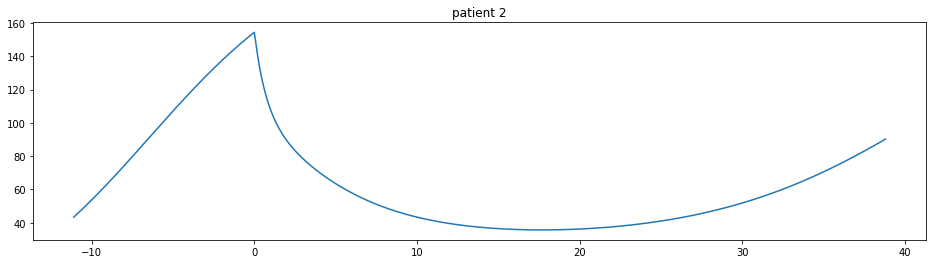

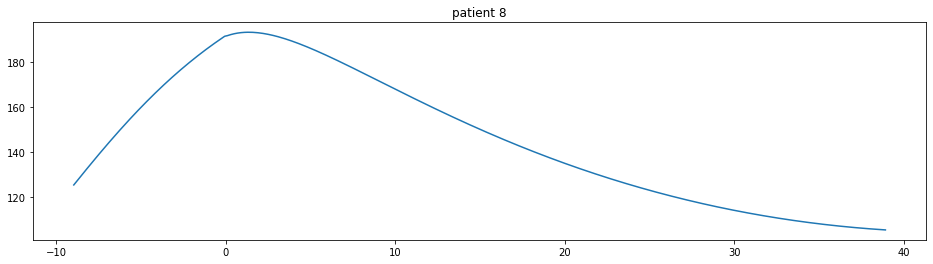

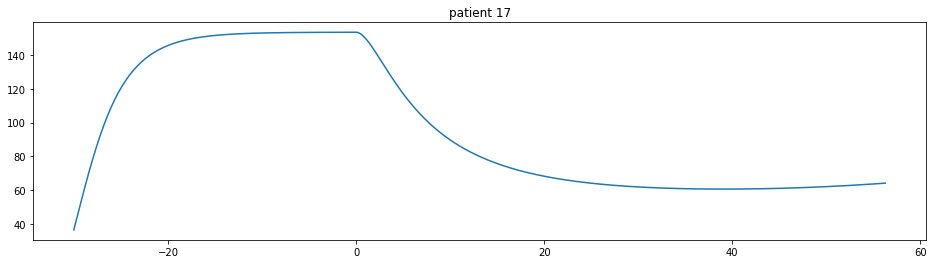

In [4]:
for pat, title in [(pat_2, 'patient 2'), (pat_8, 'patient 8'), (pat_17, 'patient 17')]:
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.set_title(title)
    ax.plot(pat.t, pat.mtd)
    plt.show()

In [5]:
def data_for_patient(pat, start_train=0, div=0.7):
    data = pat[(pat.t >= start_train)]['mtd'].to_numpy()
    trainingLength = int(len(data) * div)
    print(data[:-1].shape)
    X = data[:-1].reshape((-1, 1, 1))
    print(X.shape)
    X = torch.from_numpy(X).to(device)
    y = data[1:].reshape((-1, 1, 1))
    y = torch.from_numpy(y).to(device)
    return X[:-trainingLength], X[-trainingLength:], y[:-trainingLength], y[-trainingLength:]

In [6]:
def experiment(pat, start_train=0, transient=100, hidden_size=100):
    X, X_test, y, y_test = data_for_patient(pat, start_train)
    print(X.shape, y.shape)
    t_test = pat[pat.t >= start_train].iloc[len(y) + 1:].t
    esn = DeepESN(1, hidden_size, initializer=WeightInitializer(), num_layers=3, bias=False,
                  activation=A.relu(leaky_rate=0.5), transient=transient)
    esn.fit(X, y)
    pred = []
    p = y[-1:]
    n = len(X_test)# // 2
    for i in range(n):
        p = esn(p)
        p = torch.reshape(p, (1,1,1))
        pred.append(p.item())
    y_pred = pred
    fig = plt.figure(figsize=(16,4))
    ax = fig.gca()
    ax.plot(pat.t, pat.mtd, label='test')
    ax.plot(t_test[:n], y_pred, label='prediction')
    ax.axvline(x=start_train, ymin=0, ymax=1, color='r')
    plt.show()

In [7]:
from sklearn.metrics import mean_squared_error

In [8]:
X, X_test, y, y_test = data_for_patient(pat_2, 0)
t_test = pat[pat.t >= 0].iloc[len(y) + 1:].t

(387,)
(387, 1, 1)


In [9]:
for size in np.arange(50, 1100, 50):
    transient = 100
#     size = 100
    esn = DeepESN(1, size, initializer=WeightInitializer(), num_layers=3, bias=False,
                  activation=A.relu(leaky_rate=0.5), transient=transient)
    esn.fit(X, y)
    pred = []
    p = y[-1:]
    n = len(X_test) // 2
    for i in range(n):
        p = esn(p)
        p = torch.reshape(p, (1,1,1))
        pred.append(p.item())
    y_test_ = y_test[:len(pred)]
    print(size, mean_squared_error(y_test_.view(-1).detach().numpy(), pred))    

50 62.82720111863413
100 5.143993976235848
150 2.4269845020672305
200 2.016288711100191
250 1.4650191647410746
300 8.418622322573285
350 2.8253417527947406
400 2.048930159771282
450 1.0301212336645984
500 3.6635535045265875
550 1.3066369175898842
600 0.7307056020330502
650 0.8739309230296214
700 1.3074838980484802
750 1.762598109589161
800 1.2965009430409709
850 2.898176014551217
900 1.3624890992545045
950 2.849769080137988
1000 1.366795779778141
1050 1.7941912193102263


(387,)
(387, 1, 1)
torch.Size([116, 1, 1]) torch.Size([116, 1, 1])


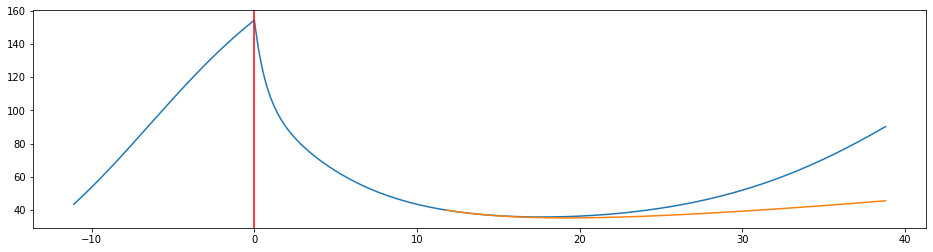

In [10]:
experiment(pat_2, 0, hidden_size=150)

(388,)
(388, 1, 1)
torch.Size([116, 1, 1]) torch.Size([116, 1, 1])


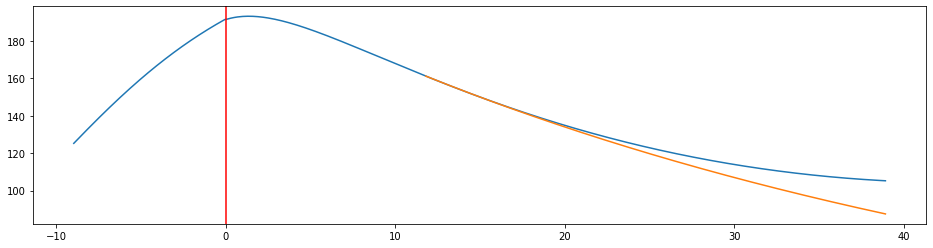

In [11]:
experiment(pat_8, 0)

(562,)
(562, 1, 1)
torch.Size([168, 1, 1]) torch.Size([168, 1, 1])


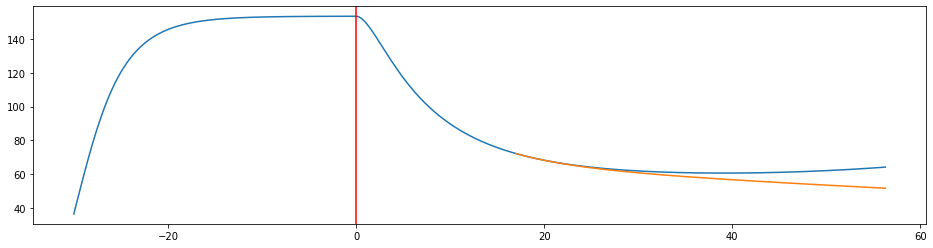

In [12]:
experiment(pat_17, 0)